In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc as pm
import bambi as bmb
import arviz as az
import statsmodels.api as sm

# Generalized Linear Models

In this section, we'll learn about an extension to linear regression called **generalized linear models**, or GLMs. In particular, GLMs are similar to linear regression, with two important extensions:

1. Instead of using the result of $X\beta$ as the average prediction, we'll apply a nonlinear function called the inverse link function or $g^{-1}$ first, so that our average prediction becomes $g^{-1}(X\beta)$. While we can use any arbitrary function here, we'll see several examples that are particularly useful.

2. Instead of assuming a normal distribution around the average prediction as our model for the likelihood of the data, we'll allow for arbitrary likelihood distributions (but still centered around the average prediction $g^{-1}(X\beta)$).

We'll work through an example that demonstrates why these kinds of models are useful, and how choosing different inverse link functions and likelihood models can change the prediction results we get.

## Linear Regression from Bayesian and frequentist perspectives

For the rest of this section, we'll work with a dataset that contains the number of wind turbines built in each state since the year 2000, focusing on Oklahoma. It contains the following columns:
* `t_built`: the number of turbines built each year
* `t_cap`: the power capacity added that year
* `year`: the year, stored as the number of years since 2000
* `totals`: the total number of turbines in the state built since 2000
* `log_totals`: the log of the total.

In [2]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
turbines.head()

ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)

# Turbines in Oklahoma from 2000 on
ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)
ok_turbines = turbines[ok_filter].sort_values('year')
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])
ok_turbines.head(n=5)

,t_state,t_built,t_cap,year,totals,log_totals
361,OK,1,100.0,1.0,1,0.000000
362,OK,113,176250.0,3.0,114,4.736198
363,OK,182,298200.0,5.0,296,5.690359
364,OK,40,60000.0,6.0,336,5.817111
365,OK,85,154500.0,7.0,421,6.042633


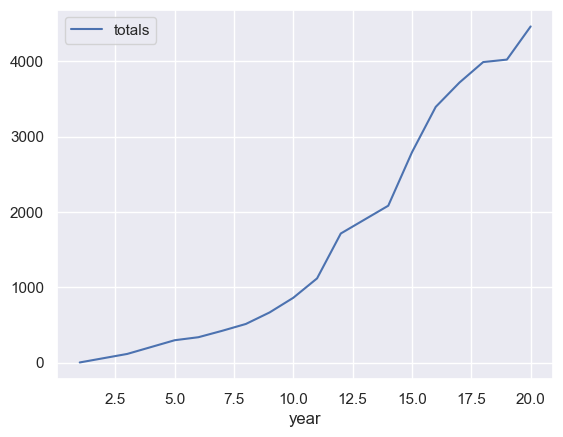

In [3]:
ok_turbines.plot('year', 'totals');

From looking at this data, we can immediately see that linear regression might not be a good fit: the relationship between the two variables seems exponential rather than linear. We can address this in one of two ways:

1. Log-transform our output data, so that we're predicting $\log($turbine count$)$, and then use a linear model.
2. Incorporate the exponential relationship into our model.

We'll start with the first approach and see that it does reasonably well, and then see how GLMs can help us do even better by taking the second approach.

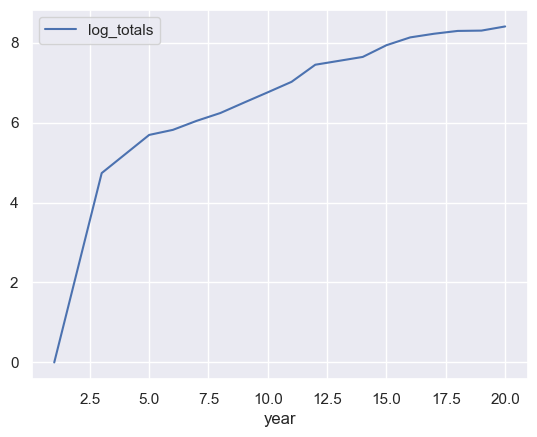

In [4]:
ok_turbines.plot('year', 'log_totals');

With the exception of the outlier at the first year ($t=0$, at the year 2000), a linear model seems like a good fit here. 

Since linear regression is a statistical model where we are estimating an unknown (model coefficients) from random data, we can approach it from either a frequentist or Bayesian paradigm. Let's see how a linear model for the log-counts will work under each of these settings.

### Turbine Data Linear Regression: Frequentist Approach

In the frequentist paradigm, we treat our unknown coefficients as fixed, and estimate them using maximum likelihood (or similar techniques). While using `scikit-learn` as we saw in the previous section was a perfectly valid way to implement linear regression in a frequentist paradigm, it doesn't support many of the generalized linear models we'll want to use throughout this chapter. So, we'll instead use the `statsmodels` package in this chapter (imported using `import statsmodels as sm`). 

We'll primarily use the `sm.GLM` class, which takes in an array or series for `y`, an array or dataframe for `X`, and a model family: we'll explore more of these families later, but for now we'll stick to OLS, which we can implement with `sm.families.Gaussian()`. In order include an intercept in our model, we need to augment our data by applying the `sm.add_constant()` function.

Here's what the model above would look like:

In [5]:
gaussian_model_intercept = sm.GLM(
    np.log(ok_turbines.totals), sm.add_constant(ok_turbines.year),
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model_intercept.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.1810
Method:                          IRLS   Log-Likelihood:                -24.472
Date:                Sat, 11 Oct 2025   Deviance:                       17.716
Time:                        13:37:17   Pearson chi2:                     17.7
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9131
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2602      0.590      5.526      0.0

The model output shows us some useful information about the model at the top, and then information about the estimated coefficient(s) at the bottom:
* `coef`, the coefficient itself,
* `std err`, the [standard error](https://en.wikipedia.org/wiki/Standard_error) (i.e., standard deviation of the estimator)
* `z`, the $z$-score for the coefficient for a hypothesis test where the null hypothesis states that it is 0,
* `P>|z|`, the $p$-value for the hypothesis test above, and
* `[0.025` and `0.975]`, the lower and upper bounds for a $95\%$ confidence interval for the estimated coefficient.

This model tells us that we can predict the log of the number of turbines $N$ in any year $t$ as follows:

$$
\log(N) = 3.26 + 0.30 \times t
$$

In most cases, we're more interested in the actual turbine count, rather than the log: so, we can exponentiate both sides to obtain:

$$
N = e^{3.26} e^{0.3t}
$$

This also tells us that according to this model, each year, the number of turbines is multiplied by $e^{0.3}$, or roughly $1.35$.

We can also visualize this prediction:

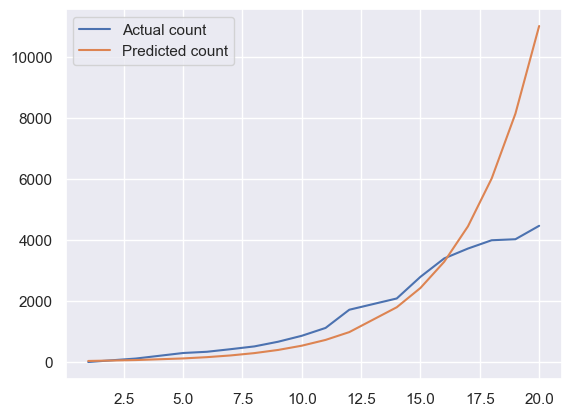

In [6]:
ok_turbines['pred_freq'] = np.exp(3.2602 + 0.3023 * ok_turbines['year'])

plt.plot(ok_turbines['year'], ok_turbines['totals'], label='Actual count')
plt.plot(ok_turbines['year'], ok_turbines['pred_freq'], label='Predicted count')
plt.legend();

We can see that the predictions from this model are reasonable from 2000-2016, but then start to diverge from reality after that.

### Turbine Data Linear Regression: Bayesian Approach

In [7]:
ok_turbines

,t_state,t_built,t_cap,year,totals,log_totals,pred_freq
361,OK,1,100.0,1.0,1,0.000000,35.251215
362,OK,113,176250.0,3.0,114,4.736198,64.528049
363,OK,182,298200.0,5.0,296,5.690359,118.119875
364,OK,40,60000.0,6.0,336,5.817111,159.812300
365,OK,85,154500.0,7.0,421,6.042633,216.220777
366,OK,91,141900.0,8.0,512,6.238325,292.539588
367,OK,153,299100.0,9.0,665,6.499787,395.796425
368,OK,195,352260.0,10.0,860,6.756932,535.499523
369,OK,257,524900.0,11.0,1117,7.018402,724.513214
370,OK,596,1127050.0,12.0,1713,7.446001,980.242510


In the Bayesian paradigm, we treat our unknown coefficients as random, and compute the posterior distribution over them, conditioned on the data we observe. While we could implement the entire model in PyMC, the Bambi package provides a convenient layer on top of PyMC that lets us specify our models with less code. We'll use the `bmb.Model` class, which takes a formula, a dataframe, and a model family (for now, we'll stick with the `gaussian` family for OLS). The formula takes the form `y ~ predictor1 + predictor2 + ...`, where each variables is a column names from the provided dataframe. Here's how we implement the model from above:

In [8]:
# The y-values are in the column `log_totals`, and the x-values are in the column `year`. So:
gaussian_model = bmb.Model(formula='log_totals ~ year', data=ok_turbines, family="gaussian")
gaussian_trace = gaussian_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can see the results using the `arviz` function `plot_posterior`:

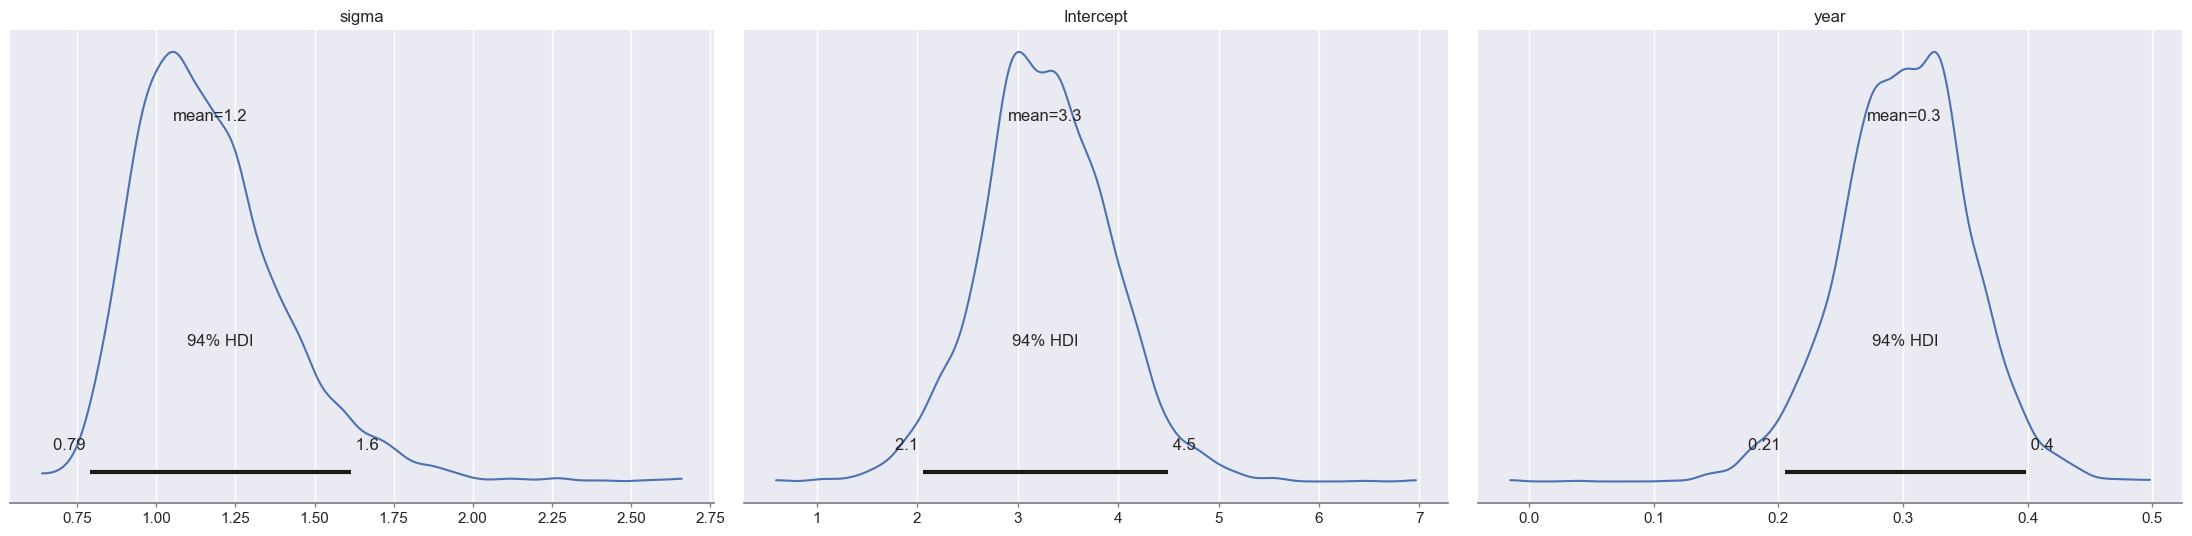

In [9]:
az.plot_posterior(gaussian_trace)
plt.tight_layout()

The first two rows each represent one coefficient. The third row, `log_totals_sigma`, is the estimated standard deviation of the data points around the average prediction. The left column shows the posterior distribution for that coefficient (by using [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) on the histogram of samples), and the right shows the trajectory of samples obtained during HMC.

Looking at the posterior distribution for the coefficient of `year` (second row), we see that the results are similar to the frequentist version: the MAP and LMSE estimates are  around 0.3, By examining the histogram, we should expect that under the posterior, this coefficient will usually be between $0.2$ to $0.4$, with values outside this range fairly unlikely. This uncertainty is reasonable: since we're only estimating these coefficients from seventeen data points, it makes sense to have some uncertainty in the coefficients we estimate. Just as before, we can interpret these estimates in the context of the data: each year, the number of turbines increases by a multiplicative factor of about $1.3$.

When we use sampling for inference, we can think of each sample as one regression line: each sample has a value of `intercept`, a value of the coefficient for `year`, and an estimated $\sigma$ for the residuals. We can therefore plot each sample as a line:

In [10]:
def identity(x):
    return x

def plot_posterior_samples(trace, turbines_df, num_lines=40, show_logy=True):
    f, ax = plt.subplots(1, 1)
    intercept = trace.posterior['Intercept'].values.flatten()
    slope = trace.posterior['year'].values.flatten()
    indices = np.random.choice(np.arange(slope.size), num_lines, replace=False)
    if show_logy:
        y_func = identity
    else:
        y_func = np.exp

    for i in indices:
        pred = y_func(intercept[i] + slope[i] * turbines_df['year'])
        ax.plot(turbines_df['year'], pred, color='gray', alpha=0.3)

    ax.scatter(turbines_df['year'], y_func(turbines_df['log_totals']))
    ax.set_xlabel('Years since 2000')
    if show_logy:
        ax.set_ylabel('log(turbine count)')
    else:
        ax.set_ylabel('turbine count')

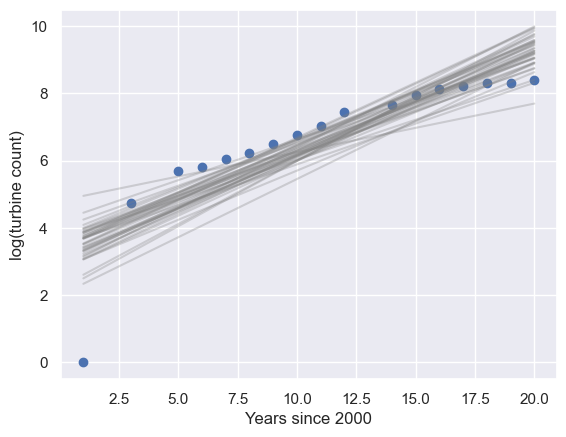

In [11]:
plot_posterior_samples(gaussian_trace, ok_turbines, show_logy=True)

In [12]:
np.identity?

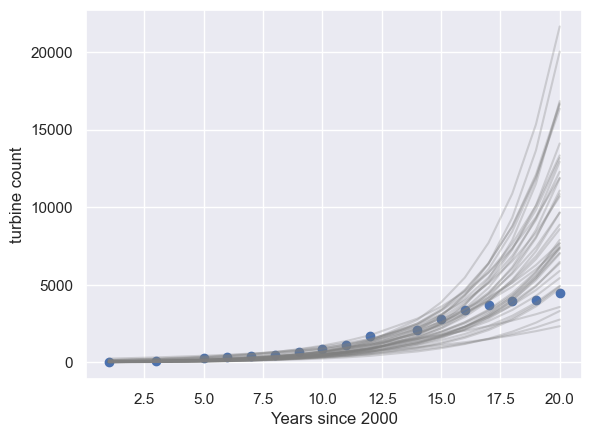

In [13]:
plot_posterior_samples(gaussian_trace, ok_turbines, show_logy=False)

These plots help us see that many of the lines have too high of a slope in the log-scale, likely due to the outlier at $t=0$. This corresponds to a too-fast exponential rise after 2016 when looking at the counts.

It's important to note that this only shows us the uncertainty in the **average** prediction `intercept + coefficient * year`: it doesn't show us the uncertainty in the variation around the average prediction. Specifically, remember that we obtain predictions in linear regression by assuming $y \sim \mathcal{N}(X\beta, \sigma^2 I)$. These lines show us the uncertainty in the average prediction $X\beta$, but don't show us how large the estimated variance $\sigma$ is: we'll come back to that later.

**Exercise**: *How might you construct similar plots to visualize the uncertainty for the frequentist results from earlier?*

#### Where are the Priors?

You may have noticed that we just implemented a Bayesian model, but never specified any priors. In this case, Bambi chooses "sensible" defaults for us, inspired by the R library `rstanarm`. These defaults are chosen to be weak, uninformative priors that don't encode much information about what the coefficients should be.

You can read more about these default choices at the [`rstanarm` documentation](https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html#default-weakly-informative-prior-distributions).

### Linear regression summary

We saw that linear regression can be implemented in both frequentist and Bayesian paradigms: at the end of the day, both approaches give us estimated coefficients, along with some measure of uncertainty. We can use those coefficients to interpret the model (as we saw above), and to make predictions for new data points. 

We saw that when making predictions with linear regression, we start by multiplying each feature by its corresponding coefficient, adding them all up to obtain an average prediction, and assuming some randomness around that average.

In order to determine the coefficients from data, we can take either a frequentist or Bayesian approach. In the frequentist paradigm, we estimated them using frequentist methods like MLE, and in the Bayesian paradigm we approximated the posterior distribution over the coefficients (conditioned on the observed data) using samples.

For the remainder of this chapter, we'll move back and forth between frequentist and Bayesian paradigms to illustrate ideas in each one.

## Beyond Linear Regression: GLMs

The regression model above works somewhat well for years before 2016, but it doesn't account for the fact that the variable we're predicting is a whole number (meaning that it takes values $0, 1, 2, 3, \ldots$). When we say that $y|\beta \sim N(X\beta, \sigma^2 I)$, and use log-transformed data for $y$, we're implicitly saying that $y$ can never be 0. We'll start by asking the question: can we use a different likelihood that is designed specifically for this kind of data? In answering this, we'll explore two examples of generalized linear models: Poisson regression and negative binomial regression.



### Poisson regression

*You may find it helpful to review [Section 7.1 of the Data 140 textbook](http://prob140.org/textbook/content/Chapter_07/01_Poisson_Distribution.html), which covers the Poisson distribution.*

Recall that the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is a distribution over counts and count-like values. It has one *positive* parameter $\lambda$ that represents its mean (and variance, too).

In Poisson regression, we're going to assume a Poisson likelihood for each $y_i$, and we'll use the linear combination $x_i^T\beta$ to help determine the parameter. The Poisson distribution is only defined for positive values of the parameter, but $x_i^T\beta$ could be negative. There are several ways to make the possibly-negative value into a positive one so we can use it for the parameter (e.g., take absolute value, square, etc.), but inspired by our log-transformation of the outputs in the previous section, we'll exponentiate.

So, we'll use $\exp(x_i^T \beta)$ as the mean. We can write out our likelihood for the observed data points $y_i$:

$$
y_i | \beta \sim \text{Poisson}(\exp(x_i^T \beta))
$$

As before, we can use this likelihood model to estimate the coefficients $\beta$ in either a frequentist or Bayesian setting. In this section, we'll choose to take a Bayesian approach, mostly so that we can take advantage of the function `plot_posterior_samples` that we wrote in the last section to help us visualize the uncertainty in our model.

Using Bambi, switching from linear regression to Poisson regression is quite straightforward:

In [14]:
poisson_model = bmb.Model(formula='totals ~ year', data=ok_turbines, family='poisson')
poisson_trace = poisson_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


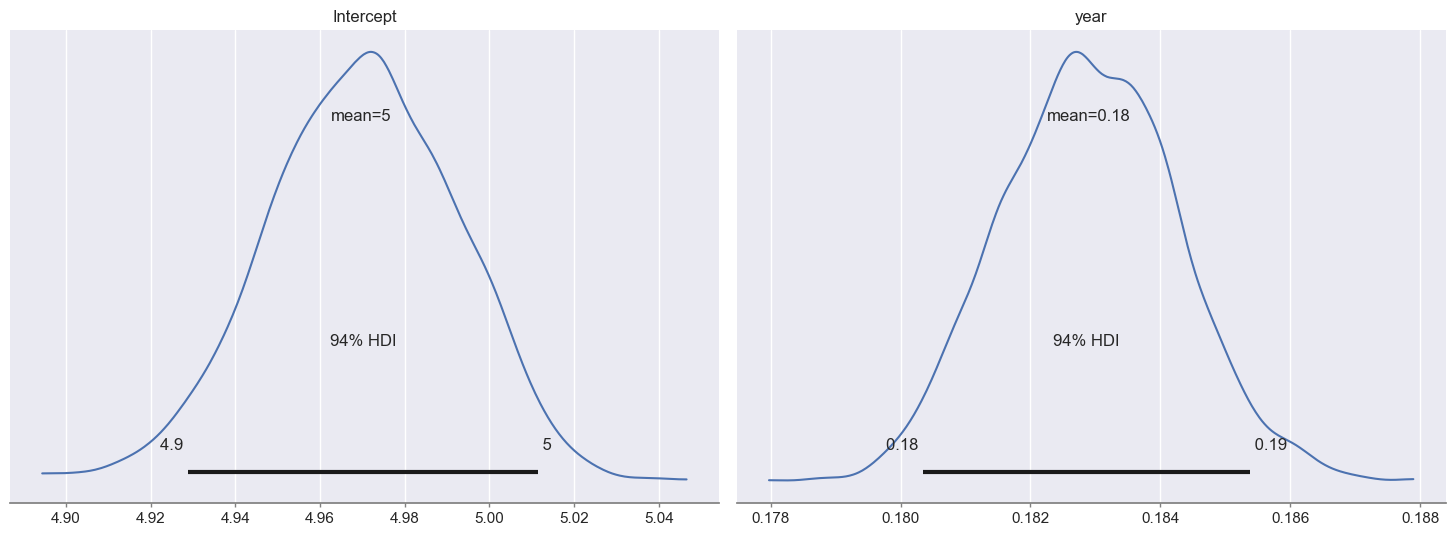

In [15]:
az.plot_posterior(poisson_trace)
plt.tight_layout()

Comparing this to the results from the Gaussian model, we can see that the posterior distributions for the two coefficients are **much** narrower. On top of that, the values of the coefficient for `year` seem much smaller: whereas before the posterior was centered around $0.3$, now it looks like the entire distribution is narrowly distributed around 0.183.

In [16]:
np.exp(0.183)

1.2008144080808307

This corresponds to only a $20\%$ average growth rate, compared to our $35\%$ average growth rate from the earlier model. The lower growth rate seems reasonable: recall that the resulting curve(s) from linear regression grew too fast, especially after 2016. But, the degree of certainty in the results is concerning: given that we only have 17 data points, our results should have a lot more uncertainty in them. We can visualize how "overconfident" the model is by plotting each sample as a line/curve using the `plot_posterior_samples` function:

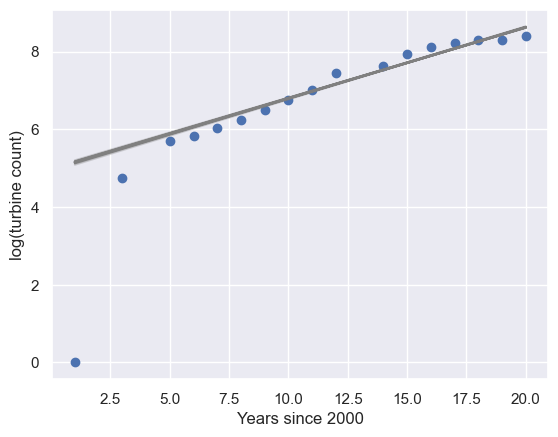

In [17]:
plot_posterior_samples(poisson_trace, ok_turbines, show_logy=True)

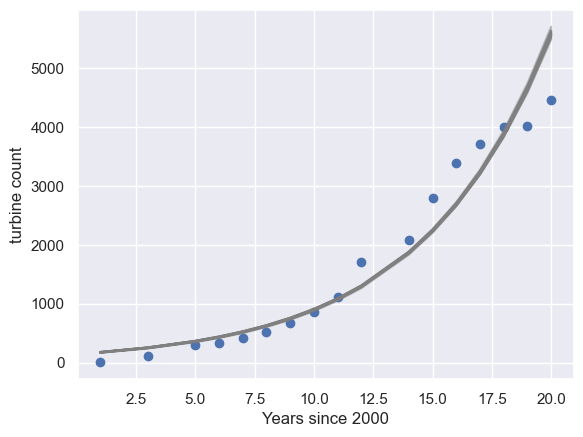

In [18]:
plot_posterior_samples(poisson_trace, ok_turbines, show_logy=False)

Just as before, it's important to remember that these lines only show us the estimated uncertainty in the average prediction $X\beta$: we aren't visualizing any of the uncertainty shown by the Poisson model itself.

Why are the results so different? 

Let's think about the implicit assumptions we're making when choosing a Poisson likelihood. In particular, one important property of the Poisson distribution is that its mean is equal to its variance. So, while the linear model could allow for an average prediction of $\log(N) = 4$ with a variance of $1.5$, the Poisson distribution requires that the mean and variance must be the same. 

This problem is compounded by the fact that the Poisson distribution is modeling the true counts rather than the log-counts: in other words, consider 2018, when the number of turbines was about 4000. A Poisson distribution with mean 4000 has a variance of 4000, or in other words, a standard deviation of only around 63. 

Clearly, the Poisson is a poor choice for fitting this data! When a model assumes a lower variance than is actually present in the data, like this Poisson model does, we say that the data are **overdispersed**: this means that they're too spread out relative to the model's assumptions). In order to solve this problem, we should choose a different distribution that gives us the ability to control the variance as well as the mean.

This wasn't a problem with the normal likelihood earlier: because the normal distribution has two separate parameters for mean and variance, we can choose them separately to reflect the fact that the variance may be higher than the mean.

### Negative binomial regression

The [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) is also a distribution over counts, but it allows for more complexity than the Poisson distribution. We can think of it one of two ways:

* It's the sum of $r$ [Geometric random variables], each with parameter $p$ (success probability).
* It's like a Poisson distribution if the mean parameter ($\lambda$ above) were also random.

There are several different ways to parametrize the negative binomial. How do we choose which one to use? There are two answers:

1. We want a parametrization that lets us choose the mean, since we want the mean value for $y_i$ to be $\exp(x_i^T \beta)$ (in other words, we want to do almost the same thing as we just did with Poisson regression, but we want to use a negative binomial distribution instead of a Poisson distribution for the observed values).
2. Since we're using PyMC through Bambi, we're limited to whichever parametrization(s) it supports.

Even though the form of the distribution is significantly more complex and manipulating it involves more work, using it in our regression model requires only a tiny change to what we were doing before:

In [19]:
negbin_model = bmb.Model(formula='totals ~ year', data=ok_turbines, family='negativebinomial')
negbin_trace = negbin_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [20]:
np.sqrt(4000)

63.245553203367585

In [21]:
ok_turbines

,t_state,t_built,t_cap,year,totals,log_totals,pred_freq
361,OK,1,100.0,1.0,1,0.000000,35.251215
362,OK,113,176250.0,3.0,114,4.736198,64.528049
363,OK,182,298200.0,5.0,296,5.690359,118.119875
364,OK,40,60000.0,6.0,336,5.817111,159.812300
365,OK,85,154500.0,7.0,421,6.042633,216.220777
366,OK,91,141900.0,8.0,512,6.238325,292.539588
367,OK,153,299100.0,9.0,665,6.499787,395.796425
368,OK,195,352260.0,10.0,860,6.756932,535.499523
369,OK,257,524900.0,11.0,1117,7.018402,724.513214
370,OK,596,1127050.0,12.0,1713,7.446001,980.242510


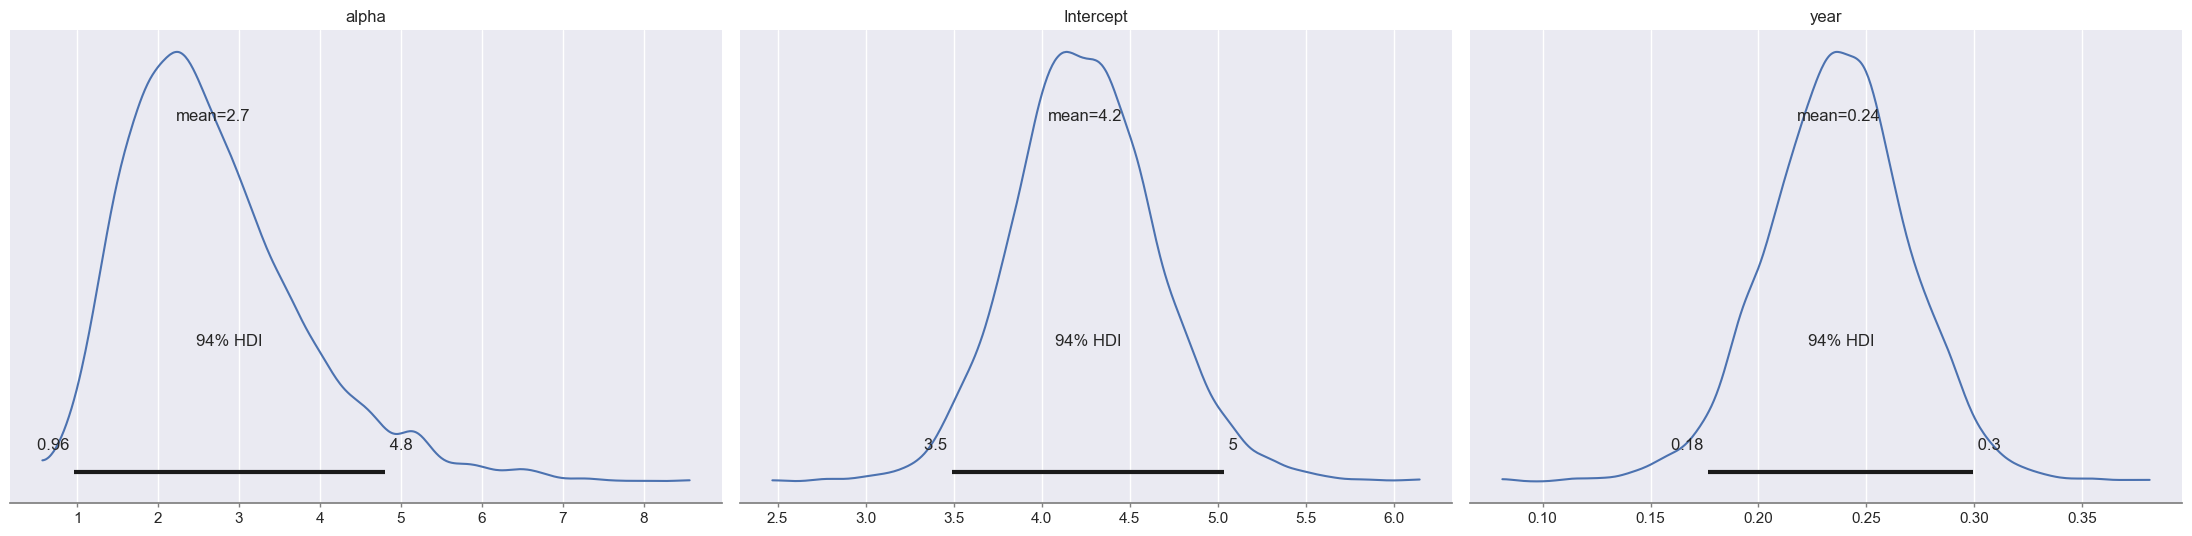

In [22]:
az.plot_posterior(negbin_trace)
plt.tight_layout()

Here, the posterior distribution for the `year` coefficient has a wider spread, and the mean is around $0.24$:

In [23]:
np.exp(0.24)

1.2712491503214047

This corresponds to a growth rate around 27%. We can visualize the uncertainty in our inference for the coefficients:

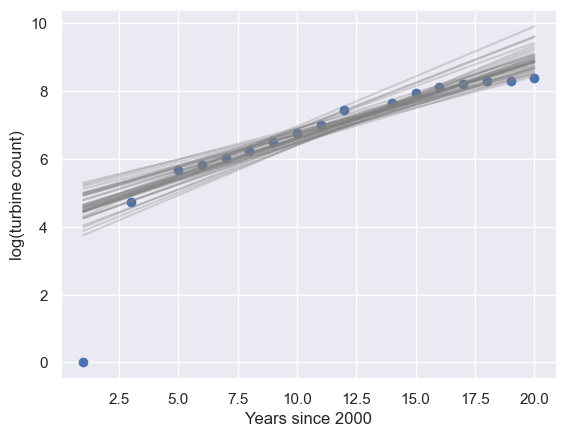

In [24]:
plot_posterior_samples(negbin_trace, ok_turbines, show_logy=True)

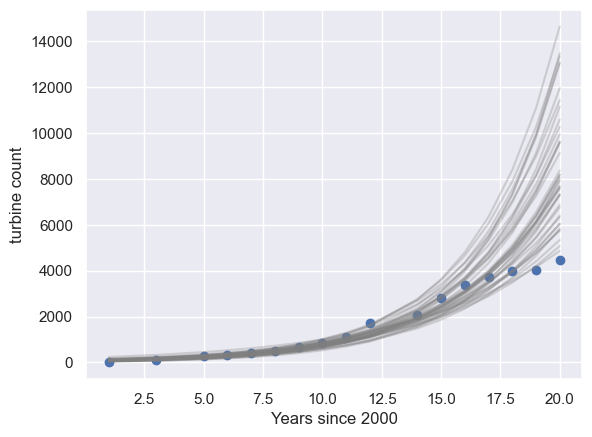

In [25]:
plot_posterior_samples(negbin_trace, ok_turbines, show_logy=False)

This seems to be a much better overall fit: the uncertainty in the various lines/curves matches up with the observed data, indicating that most of the prediction lines are somewhat reasonable given the observed data. It's important once again to remember that the uncertainty visualized here is only in the average prediction, and that we aren't visualizing the uncertainty in the estimated variance from the negative binomial model.

Comparing the Poisson model and the negative binomial model, both are very similar:
* oth models took a linear combination of the features and coefficients, with somewhat similar coefficient values
* Both models transformed the result of the linear combination using an exponential function

The key difference was our likelihood model for the observed data points around the average prediction: the Poisson model assumed a Poisson distribution, whose variance is determined by the mean. The negative binomial model, on the other hand, assumed a negative binomial distribution, whose variance could be inferred from the data as a separate variable in our model. This enabled the negative binomial model to better capture the uncertainty in the average prediction.

**Exercise**: *Implement Poisson and negative binomial regression in the frequentist paradigm using `statsmodels`. Are the results similar?*

*Hint: you may find it helpful to use `sm.families.Poisson()` and `sm.families.NegativeBinomial()`.*

## Generalized Linear Models

By now, you've seen four different versions of regression in the Bayesian setting:

* Linear regression, for predicting real-valued outputs
* Logistic regression, for predicting binary outputs (classification)
* Poisson regression, for predicting counts
* Negative binomial regression, for predicting counts

Let's review what they had in common and what was different between them:

1. For all four, computing our prediction for $y_i$ begins with computing $x_i^T \beta$. This part is a *linear* function of $x_i$, even if we do something nonlinear with it later.
   
2. Each one had a different function that we used to compute the average value of $y_i$ from $x_i^T \beta$. Since this function links the linearly transformed input $x$ to the output $y$, you might expect us to call it the **link function**: this would make a lot of sense. However, the convention is to do the opposite, and call it the **inverse link function**. As you might expect from this name, the **link function** is the inverse of the inverse link function.

3. For each one, we used a different distribution for the likelihood of the data points. In all cases, the the mean of this distribution was always output of the inverse link function above.

The following table summarizes the different choices of likelihood and link function for the four versions that we've seen:

| Regression | Inverse link function | Link function | Likelihood |
| :-- | :-- | :-- | :-- |
| Linear | identity | identity | Gaussian |
| Logistic | sigmoid | [logit](https://en.wikipedia.org/wiki/Logit) | Bernoulli |
| Poisson | exponential | log | Poisson |
| Negative binomial | exponential | log | Negative binomial |
   
These ideas form the basis for what are known as Generalized Linear Models, or GLMs. Once we choose a link function and a likelihood distribution, our model is fully specified, and we can approximate the posterior distribution over the coefficients in $\beta$.


### GLM Workflow

When making predictions with a GLM, here's a general sequence to follow:

1. **Formulate your prediction problem** by determining what you're trying to predict ($y$) and what you're using to predict it ($x$). This depends on the real-world problem that you're trying to solve, and what data might be available to help you solve it.

2. **Gather training data** in the form of $(x, y)$ pairs. This may require searching through publicly available data, private or proprietary datasets you have access to, or even going out and gathering new data or paying for data to be gathered. It's important to make sure that any data $x$ that you gather will be useful in predicting $y$. At this step, it's also helpful to determine any features you may want to compute, especially features that might be derived from existing columns in $x$.

3. **Choose a link function and likelihood model** that make sense for your data. For example, if your output is binary, then logistic regression might make sense. If your outputs are count-valued, then Poisson or negative binomial regression might be a good fit. You can see more possibilities at the [Wikipedia page for generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function).

4. **Fit the model using training data**: this usually involves using Bambi, statsmodels, or `scikit-learn` or another package to computationally determine the coefficients of the model that work on the training dataset.

5. **Check that your model is actually a good fit for the data**: this step, often called model checking, involves making sure that the model makes and will make good predictions on your dataset. We'll spend the next section exploring model checking.

6. **Interpret the coefficients**: one benefit of GLMs is that the coefficients have an intuitive interpretation. In linear regression, a coefficient tells us how much the output is predicted to increase if the corresponding predictor increases by a certain amount. We saw earlier in this section that in Poisson and negative binomial regression (or in linear regression with log-transformed $y$-values), the coefficients indicate a multiplicative increase by a factor of $\exp(\beta)$. In logistic regression, the coefficients tell us how much the log-odds increases.

7. **Generate new predictions** from new $x$-values for new data where $y$ is unknown. Usually, we use prediction models to help us make predictions for future data points. These predictions are made by multiplying the coefficients that we learned in step 4 by the predictors for the new points and applying the inverse link function. This is usually handled computationally: most packages that you can use to fit models also have the ability to predict for new data points.

8. **Report uncertainty** for coefficients and new predictions: since we fit our models using random data that come with some inherent uncertainty, anything we derive from that data also has uncertainty. This includes the estimated coefficients that we fit in step 4 and interpreted in step 6, as well as the new predictions that we made in step 7. We'll spend more time on quantifying uncertainty later this chapter.